<h1> Approximating a Region of the Sine Function </h1>

In this notebook we will approximate a region of the sine function with a neural network to get a sense of how architecture and hyperparameters affect neural network performance.

<img src="../data/sine_wave.gif" width="1200" align="center">


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

from tqdm.auto import trange, tqdm

<h2> Pytorch Datasets and Dataloaders </h2>
<b> *Basics we will cover in more detail later on, but for now...</b><br>
Pytorch has a huge number of functionalities that make training our neural networks very easy! One of those functionalities is the Pytorch dataset and dataloader (they are real life-savers!). The "dataset" class is an object that "stores" our dataset either directly (it loads all the data in the initialisation function) or indirectly (it loads the image paths during the initialisation function and only loads them when it needs to - for large image-based datasets this is usually the only way to do it). We will see how we can create our own Pytorch dataset soon!<br>
These datasets are then used to create a "dataloader" object that is "iterable". The Pytorch dataloader will take our dataset and randomly shuffle it (if we tell it to), it will also divide the dataset into "mini-batches," which are groups of datapoints of a fixed size (the batch size). Our Neural Network is then trained through a single step of GD on this mini-batch. As we iterate through the dataloader, the dataloader will pass us a new unique mini-batch until the whole dataset has been passed to us. One whole loop through the dataset is called an "epoch", during every epoch the dataset is re-shuffled so the mini-batches are all random. This random sampling of the dataset and training on mini-batches (instead of performing GD on the whole dataset) is called Stochastic Gradient Descent (SGD)<br>
Note: If the whole dataset is not evenly divided into mini-batches, then in the last iterator, we will just pass whatever is left over!

<h3> Creating a Pytorch dataset </h3>
The dataset we will be creating will be points from a "noisey" sine wave.<br>
The Pytorch dataset class has three essential parts:<br>
The __init__ function (as most Python classes do)<br>
The __getitem__ function (this is called during every iteration)<br>
The __len__ function (this must return the length of the dataset)

In [2]:
# Create a "SineDataset" class by inheriting the Pytorch Dataset class
class SineDataset(Dataset):
    """ 
    Noisy sine wave dataset
    num_datapoints - the number of data points you want
    """
    def __init__(self, num_datapoints):
        # Let's generate the noisy sine wave points
        
        # Create "num_datapoints" worth of random x points using a uniform distribution (0-1) using torch.rand
        # Then scale and shift the points to be between -9 and 9
        self.x_data = torch.rand(num_datapoints, 1)*18 - 9
        
        # Calculate the sin of all data points in the x vector and the scale amplitude down by 2.5
        self.y_data = torch.sin(self.x_data) / 2.5
        
        # Add some Gaussian noise to each datapoint using torch.randn_like 
        # (scale the noise down a bit by about 20 - see how different noise levels affect your model)
        # Note: torch.randn_like will generate a tensor of Gaussian noise the same size 
        # and type as the provided tensor
        self.y_data += torch.randn_like(self.y_data) / 20

    def __getitem__(self, index):
        # This function is called by the dataLOADER class whenever it wants a new mini-batch
        # The dataLOADER class will pass the dataSET class a number of datapoint indexes (mini-batch of indexs)
        # It is up to the dataSET's __getitem__ function to output the corresponding input datapoints 
        # AND the corresponding labels
        return self.x_data[index], self.y_data[index]
    
        # Note:Pytorch will actually pass the __getitem__ function one index at a time
        # If you use multiple dataLOADER "workers" multiple __getitem__ calls will be made in parallel
        # (Pytorch will spawn multiple threads)

    def __len__(self):
        # We also need to specify a "length" function, Python will use this function whenever
        # You use the Python len(function)
        # We need to define it so the dataLOADER knows how big the dataSET is!
        return len(self.x_data)

Now that we've defined our dataset, lets create an instance of it for training and testing and then create  dataloaders to make it easy to iterate

In [3]:
n_x_train = 30000   # the number of training datapoints
n_x_test = 8000     # the number of testing datapoints
batch_size = 16

# Create an instance of the SineDataset for both the training and test sets
dataset_train = SineDataset(n_x_train)
dataset_test  = SineDataset(n_x_test)

# https://pytorch.org/docs/stable/data.html #torch.utils.data.DataLoader
# Now we need to pass the dataSET to the Pytorch dataLOADER class along with some other arguments
# dataset - the dataset for this dataloader
# batch_size - the size of our mini-batches
# shuffle - whether or not we want to shuffle the dataset (True for training False for testing)

data_loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
data_loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

Lets visualise the dataset we've created!!

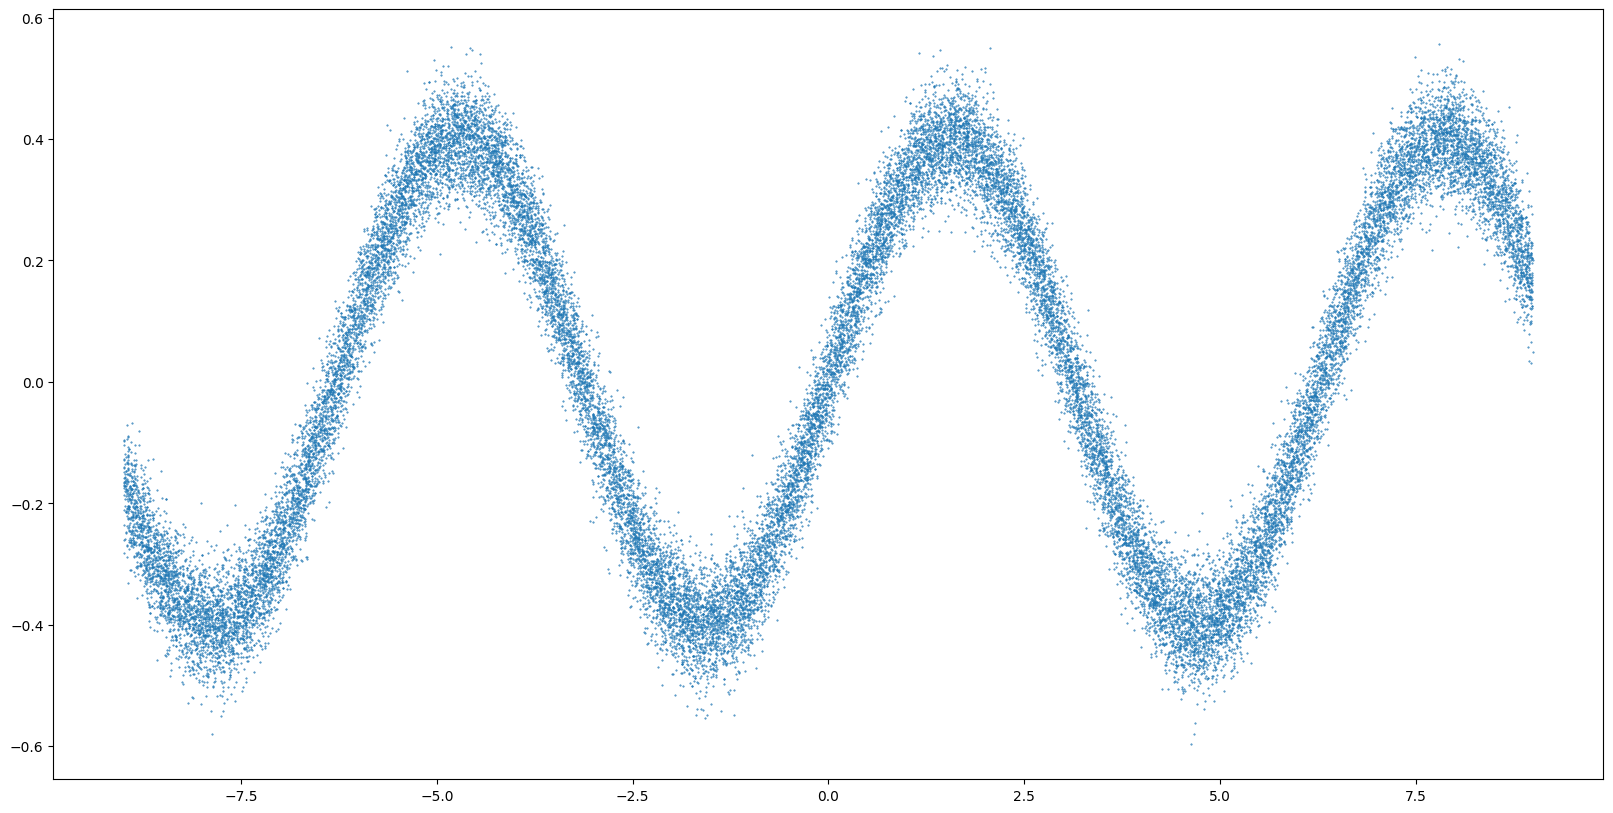

In [4]:
fig = plt.figure(figsize=(20, 10))
plt.scatter(dataset_train.x_data, dataset_train.y_data, s=0.2)
# Note:see here how we can directly access the data from the dataset class

<h2> Neural Network Architecture</h2>
<b> Non-Linear function approximators! </b> <br>

Until now, we have only created a single linear layer with an input layer and an output layer. In this section, we will start to create multi-layered networks with many "hidden" layers separated by "activation functions" that give our networks "non-linearities". If we didn't have these activation functions and simply stacked layers together, our network would be no better than a single linear layer! Why? Because multiple sequential "linear transformations" can be modeled with just a single linear transformation. This is easiest to understand with matrix multiplications (which is exactly what happens inside a linear layer).<br>

$M_o = M_i*M_1*M_2*M_3*M_4*M_5$<br>
Is the same as<br>
$M_o = M_i*M_T$<br>
Where<br>
$M_T = M_1*M_2*M_3*M_4*M_5$<br>

Aka multiplication with several matrices can be simplified to multiplication with a single matrix.<br>

So, what are these nonlinear activation functions that turn our simple linear models into a powerful "nonlinear function approximator"? Some common examples are:<br>
1. ReLU
2. sigmoid
3. tanh

Simply put, they are "nonlinear" functions, the simplest of which is the "rectified linear unit" (ReLU), which is "piecewise nonlinear".

NOTE: The term "layer" most commonly refers to the inputs or outputs of the weight matrix or activation functions and not the linear layer or activation layer themselves. Output layers between two "linear layers" are called "hidden layers". You can imagine them "inside" the neural network, with us only being able to see the input and output layers. To confuse things even further, the outputs of activation functions are also commonly called "activations"

Why do we want a linear function approximator? Because many processes, tasks, and systems in the real world are non-linear. "Linear" in basic terms refers to any process that takes inputs, scales them, and sums them together to get an output. 


## Regression or Classification Neural Networks do only one thing....
In this notebook, we are performing regression, which, as we've seen, is very similar to classification! Both regression and classification can be thought of as producing a distribution over possible values for a given input. In classification, the model produces the probability that the input belongs to a particular category, where the probabilities define a discrete categorical distribution (or a Bernoulli distribution for binary classification)!
In regression our model also produces a distribution on the output, however it may be less clear how. The output of the model is the expectation (mean) of a normal distribution with sigma (standard deviation) equal to 1 (assuming we are using the basic MSE loss). In fact, the Mean Squared Error (MSE) loss we use can be thought of in the same way as the cross-entropy loss used in classification! With the MSE loss, we are trying to learn a model that produces a normal distribution (conditioned on the input data) such that the target value has the highest likelihood! Where does the normal distribution have the highest likelihood? At the mean!!<br>
For more information as to how we get the MSE loss from the Maximum likelihood of a normal distribution, have a look at the following:<br>
[Blog: MSE is Cross Entropy at heart by Moein Shariatnia](https://towardsdatascience.com/mse-is-cross-entropy-at-heart-maximum-likelihood-estimation-explained-181a29450a0b)

<h3>Pytorch nn.Module</h3>
Now we can define a Pytorch model to be trained!<br>
To do so, we use the Pytorch nn.Module class as the base for defining our network. Just like the dataset class, this class has a number of important functions.

In [5]:
# Define our network class by using the nn.module
class ShallowLinear(nn.Module):
    '''
    A simple, general-purpose, fully connected network
    '''
    # Here we initialise our network and define all the layers we need
    def __init__(self, input_size, output_size, hidden_size):
        # Perform initialization of the PyTorch superclass, which will allow us to inherit 
        # functions from the nn.Module class
        super(ShallowLinear, self).__init__()
        
        # Define four linear layers for our model with the same hidden size for all
        # Note: The output of one layer must be the same size as the input for the next!
        self.l1 = nn.Linear(input_size, hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, hidden_size)
        self.l4 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # This function is important, and we must create it, or PyTorch will give us an error!
        # This function defines the "forward pass" of our neural network
        # and will be called when we simply call our network class
        # aka we can do net(input) instead of net.forward(input)
        
        # Let's define the sequence of events for our forward pass!
        # We'll use a tanh activation function here
        # You can experiment with other activation functions!
        x = self.l1(x)
        x = torch.tanh(x)
        
        x = self.l2(x)
        x = torch.tanh(x)
        
        x = self.l3(x)
        x = torch.tanh(x)

        # No activation function on the output!!
        x = self.l4(x)
        
        # Note we re-use the variable x as we don't care about overwriting it 
        # though in later labs we will want to use earlier hidden layers
        # later in our network!
        return x

## Define hyperparameters,  model and optimizer

Here we define the following parameters for training:

- batch size (which has already been defined)
- learning rate
- number of training epochs
- optimizer
- loss function

Ideally, numeric parameters would be tested empirically with an exhaustive search. When testing manually, it is recommended to maximize the model fit with one parameter at a time to avoid confounding your results. 

Try these learning rates:
- 5e-2, 1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 5e-5

Try these optimizers:
- `optim.SGD(shallow_model.parameters(), lr=learning_rate)`
- `optim.Adam(shallow_model.parameters(), lr=learning_rate)`

[Youtube: Optimizers - EXPLAINED! by CodeEmporium](https://youtu.be/mdKjMPmcWjY?si=VtjuF_QlPHAzj2Sx)

See the PyTorch documentation pages for an extensive list of options:
- Optimizers: http://pytorch.org/docs/master/optim.html#algorithms
- Loss: http://pytorch.org/docs/master/nn.html#id46

Read this page for a detailed comparison of optimizers: http://ruder.io/optimizing-gradient-descent/



In [12]:
# Define the hyperparameters
learning_rate = 1e-2
n_epochs = 100

# Create model
shallow_model = ShallowLinear(input_size=1, hidden_size=128, output_size=1)

# Initialize the optimizer with the above parameters
optimizer = optim.SGD(shallow_model.parameters(), lr=learning_rate)
# optimizer = optim.Adam(shallow_model.parameters(), lr=learning_rate)

# Define the loss function
loss_fn = nn.MSELoss()

## Initiate training, plot testing results
Here we put all the previous methods together to train and test the model. This problem is an unusual one in that our loss is the best quantitative metric of the model performance. Classification problems require further analysis of true/false positives/negatives.

Rerun this cell several times without editing any parameters. Is the result the same?

Try a larger batch size, how is the training time affected?

Look at the slope and noise level of the loss plot. Does it look like the training converged on a local minimum?

Try some different hyperparameters and see how accurate you can get your model

In [13]:
# Here we create two lists to store the loss values from training and testing
training_loss_logger = []
testing_loss_logger = []
# Note: create them outside of the train/test cell so they don't get overwritten 
# If we want to run the cell again

In [14]:
# The main train/test cell
# This will run one epoch of training and then one epoch of testing n_epochs times
for epoch in tqdm(range(n_epochs), desc="Epochs", leave=False):
    # Perform training Loop!
    for x, y in tqdm(data_loader_train, desc="Training", leave=False):

        # Run forward calculation
        y_train_hat = shallow_model.forward(x)
        
        # Compute loss.
        loss = loss_fn(y_train_hat, y)
        
        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable weights
        # of the model)
        optimizer.zero_grad()
        
        # Backward pass: compute the gradient of the loss with respect to the model
        # parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()

        # Log the loss so we can visualise the training plot later
        training_loss_logger.append(loss.item())

    # Perform a test Loop!
    # While we are within a "with torch.no_grad():" block, Pytorch will not construct the computational graph
    # This helps speed up computation and saves memory while we are not training
    with torch.no_grad():
        # Create a variable to accumulate the test loss so we can take the average
        test_loss_accum = 0
        for i, (x, y) in enumerate(tqdm(data_loader_test, desc="Testing", leave=False)):

            # Run forward calculation
            y_test_hat = shallow_model.forward(x)
            
            # Compute loss.
            loss = loss_fn(y_test_hat, y)
            
            # Log the loss so we can visualise the training plot later
            testing_loss_logger.append(loss)
            test_loss_accum += loss
            
        test_loss_accum /= (i + 1)
        
print("Epoch [%d/%d], Average Test Loss %.4f" %(epoch, n_epochs, test_loss_accum))

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch [99/100], Average Test Loss 0.0028


<h3>Lets visualise our results!</h3>

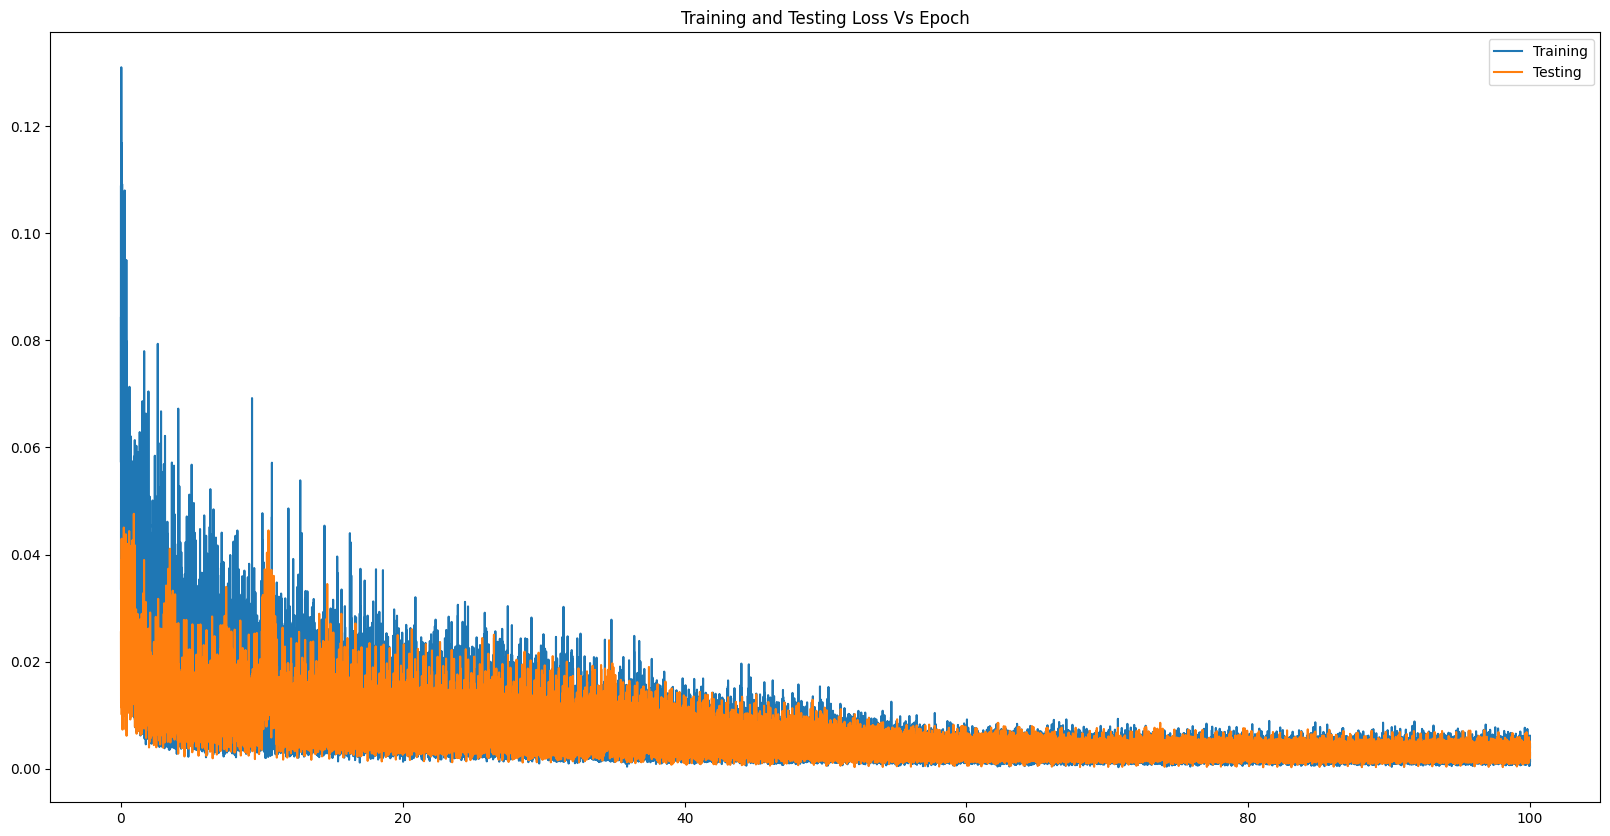

In [15]:
# Plot out the test and train losses!
fig = plt.figure(figsize=(20, 10))
plt.plot(np.linspace(0, n_epochs, len(training_loss_logger)), training_loss_logger)
plt.plot(np.linspace(0, n_epochs, len(testing_loss_logger)), testing_loss_logger)
title = plt.title("Training and Testing Loss Vs Epoch")
legend = plt.legend(["Training", "Testing"])

In [16]:
# Perform one last epoch over the testing set, logging the model's outputs!
# Perform a test Loop!
test_outputs = []
# Perform a test Loop!
with torch.no_grad():
    for x, y in data_loader_test:
        # Run forward calculation
        y_predict = shallow_model(x)
        test_outputs.append(y_predict.detach().cpu().numpy())
        
test_outputs = np.concatenate(test_outputs)

Text(-9, 0.48, '- Sine wave (with noise)')

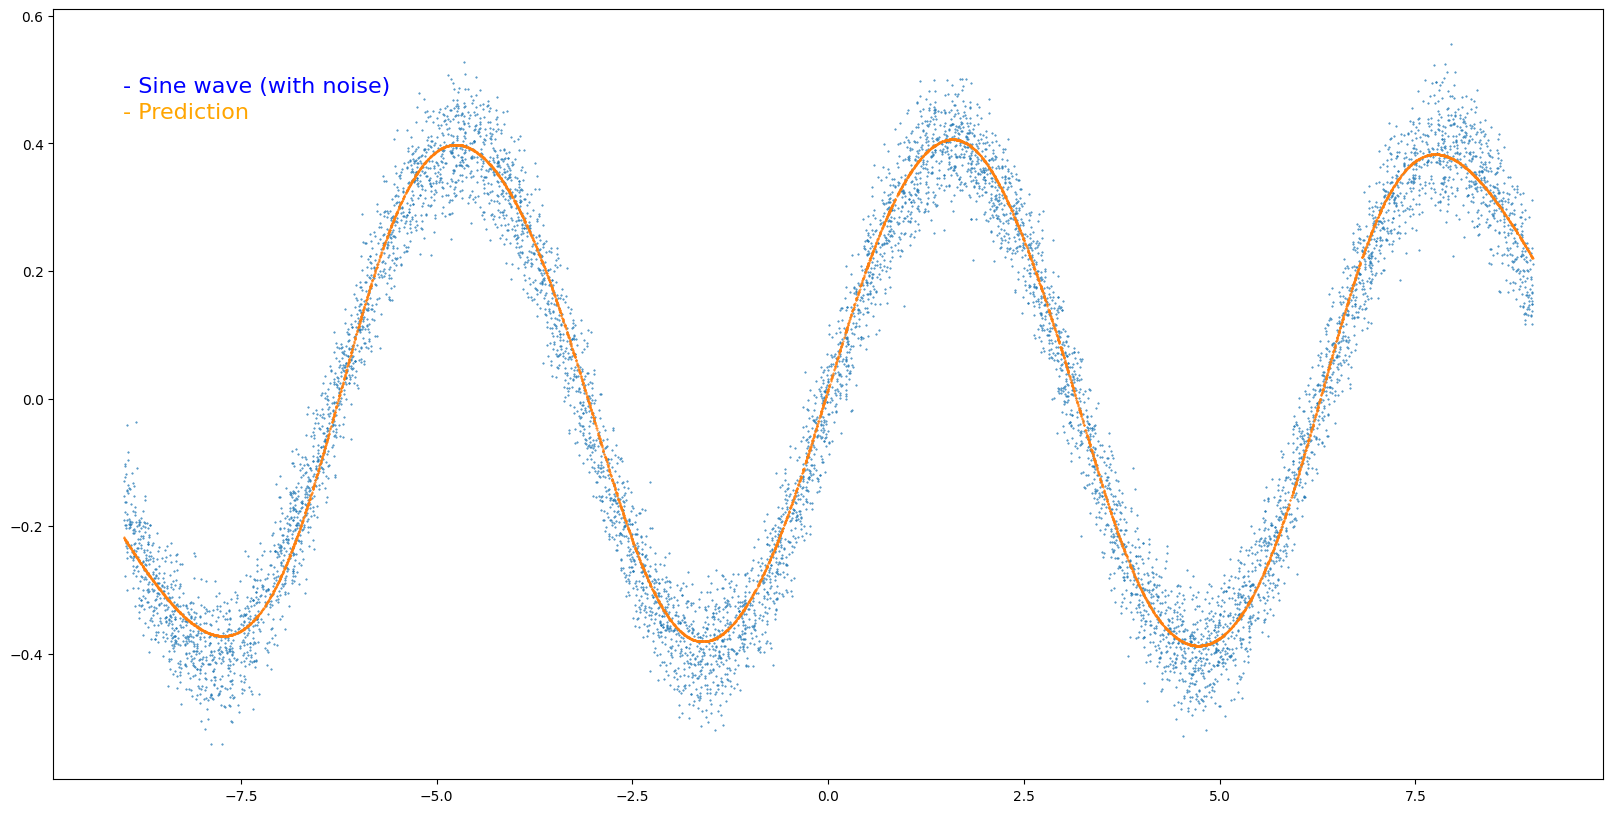

In [17]:
# Plot the test data against the model's predicted outputs. How accurate does it look??
fig = plt.figure(figsize=(20, 10))
plt.scatter(dataset_test.x_data, dataset_test.y_data, s=0.2)
plt.scatter(dataset_test.x_data, test_outputs, s=0.2)
plt.text(-9, 0.44, "- Prediction", color="orange", fontsize=16)
plt.text(-9, 0.48, "- Sine wave (with noise)", color="blue", fontsize=16)